Scaler parameters:
{
    "mean": [
        0.0,
        0.6645230870132275,
        6.154356330273655,
        0.6808673101380469,
        4.8871244307589965,
        263.21159192325325,
        0.6864503845431057,
        -15.672775404128563,
        0.0014394662891427316,
        0.24834608380402828,
        27.117974125347715,
        0.686553378629333,
        -19.16496224336055,
        0.013211706544853048,
        5.321542929342658,
        6.08604569981789,
        395.15950144888524,
        395.15950144888524,
        438.09961979904864,
        0.686553378629333,
        -19.16496224336055,
        0.70385851860944,
        29.467038693780548,
        0.1618629846615833
    ],
    "scale": [
        1.0,
        13.269447761412408,
        20.187031418929696,
        13.636423000275762,
        20.74561353927207,
        121.06800614360809,
        12.992114586870263,
        36.58809941209324,
        1.6856073841418964,
        0.4320535921193468,
        21.47121898082441

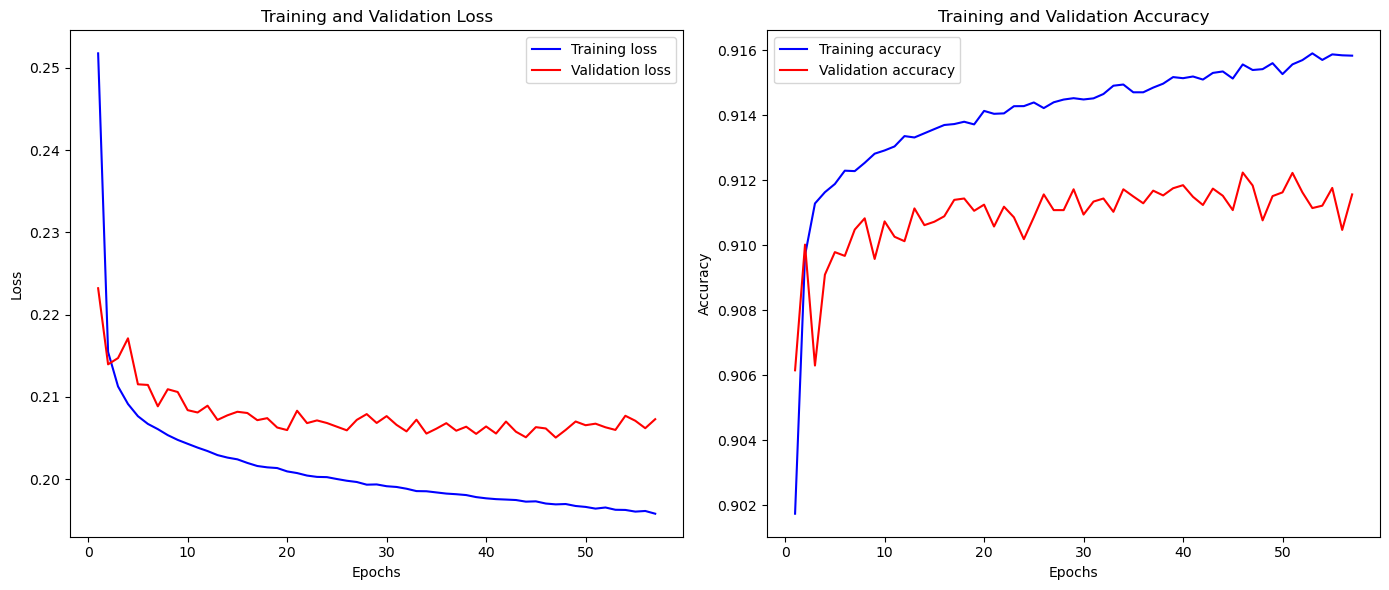

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import json
import matplotlib.pyplot as plt

# Load and prepare the dataset
file_path = 'goal_ticks.csv'

# Define column names based on the provided structure
column_names = [
    "kart_ID", "ball_X", "ball_Z", "ball_aim_X", "ball_aim_Z", "ball_node", "previous_X", "previous_Z", "ball_heading",
    "ball_appr_goal", "dist_to_ball", "kart_X", "kart_Z", "vel_X", "vel_Z", "speed", "steer", "accel", "kart_node", 
    "target_encoded", "target_pos_X", "target_pos_Z", "kart0_sector", "kart1_sector", "kart0_X", "kart0_Z", "kart1_X", 
    "kart1_Z", "has_powerup", "goal"
]

df = pd.read_csv(file_path, header=None, names=column_names)

# Drop the specified columns
df = df.drop(columns=["target_encoded", "target_pos_X", "target_pos_Z", "steer", "accel"])

# Check for NaN values and fill/drop them
df = df.fillna(0)

# Extract features and labels
X = df.iloc[:, :-1].values  # All columns except the last one (goal)
y = df['goal'].values  # The 'goal' column as binary

# Normalize all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler parameters for later use
scaler_params = {
    "mean": scaler.mean_.tolist(),
    "scale": scaler.scale_.tolist()
}

print("Scaler parameters:")
print(json.dumps(scaler_params, indent=4))

with open('scaler_parameters.json', 'w') as f:
    json.dump(scaler_params, f)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Keeping the target as a 2D tensor for BCELoss

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Prepare data loaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define the neural network architecture
class ScoringModel(nn.Module):
    def __init__(self, num_inputs=24):  # Set to 24 inputs after dropping target_encoded, target_pos_X, target_pos_Z, steer, and accel
        super(ScoringModel, self).__init__()
        self.layer1 = nn.Linear(num_inputs, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 1)  # Binary classification
        self.leaky_relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.leaky_relu(self.layer1(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer2(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer3(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer4(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer5(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.output_layer(x))
        return x

# Initialize the model with 24 inputs
model = ScoringModel(num_inputs=24)

# Set up the loss function and optimizer with L2 regularization
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)  # L2 regularization (weight decay)

# Training function with early stopping
def train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=100, patience=10):
    model.train()
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        val_loss, val_accuracy = validate_model(val_loader, model, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

# Validation function
def validate_model(val_loader, model, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(val_loader), correct / total

# Train and validate the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=100)

# Save the trained model for deployment
model.eval()

example_input = torch.rand(1, X_train.shape[1])  # Generate a random example input
traced_script_module = torch.jit.trace(model, example_input)
traced_script_module.save("soccer_ai_model.pt")

# Print the weights of the output layer after training
print("Weights of the output layer after training:")
print(model.output_layer.weight)
print("Bias of the output layer after training:")
print(model.output_layer.bias)

# Example output
example_output = model(example_input)
print("Example output:", example_output.item())

# Plotting the training and validation loss and accuracy
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("training_validation_plots.png")
plt.show()


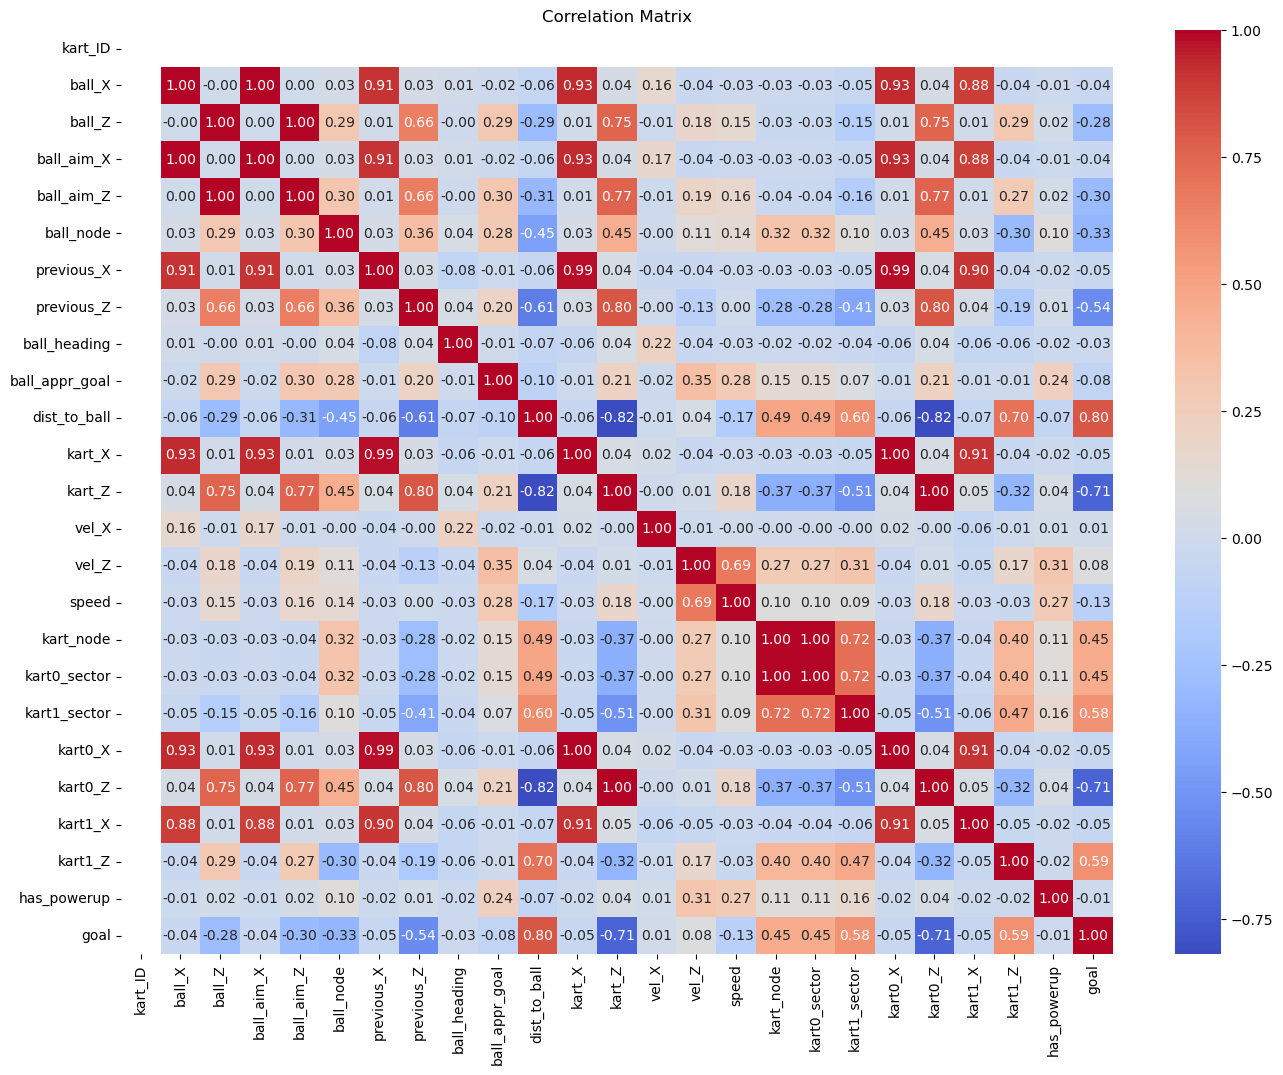

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()